# CMSC320 Final Tutorial

Matthew Paulson, Sagar Saxena, Matthew Hamer

12.18.2020

For the past few months, we have been seeing the consequences of the COVID-19 Pandemic. The workforce is one area that has been negatively impacted by this pandemic. Many jobs have been lost across various industries and we wanted to analyze these trends to understand which industries were more heavily impacted than others. [Research has shown](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7120200/) that the chances of pandemics occuring are increasing due to globalization and climate change. Because of this, understanding the effects that pandemics have on industries is crucial for better preparing for the next pandemic.


In this tutorial, we will be looking at the impact of COVID-19 on employment across different industries in the US. This tutorial is broken down into the following sections:

* Data Preprocessing - obtaining relevant information on COVID-19 cases and employment across industries over time and tidying this data
* Data Exploration - exploring what trends exist in the data
* Data Modeling - creating models that fit the trends that we had identified


## Data Preprocessing

In this section, we collect the data on COVID-19 Cases from the Center of Disease Control and employment from the Bureau of Labor Statistics. There are three subsections:

* COVID-19 Cases and Deaths Data
* Employment Data
* Merging Covid and Employment Data

### COVID-19 Cases and Deaths Data

This dataset has been obtained through the CDC. If, for any reason, the link below does not work, visit the original source [here](https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36/data) to obtain a fresh link. The data itself is a csv file which we can read in using pandas.

In [ ]:
!wget https://data.cdc.gov/api/views/9mfq-cb36/rows.csv
!mv rows.csv covid.csv

--2020-12-18 20:51:24--  https://data.cdc.gov/api/views/9mfq-cb36/rows.csv
Resolving data.cdc.gov (data.cdc.gov)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cdc.gov (data.cdc.gov)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv’

rows.csv                [            <=>     ]   1.48M   313KB/s    in 4.8s    

2020-12-18 20:51:29 (313 KB/s) - ‘rows.csv’ saved [1549363]



In [ ]:
import pandas as pd

covid = pd.read_csv("covid.csv")
covid.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,05/04/2020,KY,5245,5245.0,0.0,115,0.0,261,261.0,0.0,8,0.0,05/05/2020 05:25:08 PM,Agree,Agree
1,12/08/2020,OK,205999,171497.0,34502.0,0,0.0,1752,1680.0,72.0,0,0.0,12/09/2020 02:45:40 PM,Agree,Agree
2,04/30/2020,IA,7145,NaN,NaN,302,0.0,162,NaN,NaN,14,0.0,05/01/2020 09:00:19 PM,Not agree,Not agree
3,03/05/2020,GA,2,NaN,NaN,-5,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
4,02/08/2020,WA,1,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,NaN,NaN


We can see that this dataset has many columns, but there are only a few that are relevant for this tutorial:
* tot_cases - The number of total COVID-19 Cases by the submision date
* tot_death - The number of total COVID-19 Deaths by the submission date
* submission_date - The date at which the total number of cases and deaths had been recorded

We don't need data by state as our employment data is not as detailed as this COVID dataset. We can group by the state to get the totals for the entire country.

Let's filter this data down to only include the relevant columns

In [ ]:
covid = covid[["submission_date", "tot_cases", "tot_death"]]
covid = covid.groupby("submission_date").aggregate("sum").reset_index()
covid.head()

,submission_date,tot_cases,tot_death
0,01/22/2020,1,0
1,01/23/2020,1,0
2,01/24/2020,2,0
3,01/25/2020,2,0
4,01/26/2020,5,0


### Employment Data

This data has been obtained through the Bureau of Labor Statistics and includes the Employment By Selected Industry. The original data can be found [here](https://www.bls.gov/charts/employment-situation/employment-levels-by-industry.htm). The data is an html file that we can obtain using the requests library and parse using the beautiful soup and pandas libraries to get a dataframe.

In [ ]:
import requests
from bs4 import BeautifulSoup

r = requests.get("https://www.bls.gov/charts/employment-situation/employment-levels-by-industry.htm", 
                 headers= {'User-Agent': 'Safari/13.1'})
soup = BeautifulSoup(r.text, 'html.parser')
table = soup.find_all("table")[0]
bls = pd.read_html(str(table))[0]
bls.head()

,Month,Total nonfarm,Total private,Mining and logging,Construction,Manufacturing,Wholesale trade,Retail trade,Transportation and warehousing,Utilities,Information,Financial activities,Professional and business services,Education and health services,Leisure and hospitality,Other services,Government,Federal government,State government,Local government
0,Nov 2000,132556,111796,604,6817,17202,5857.9,15339.2,4435.3,599.4,3685,7823,16886,15410,11946,5191,20760,2737.0,4809.0,13214.0
1,Dec 2000,132709,111905,602,6792,17181,5836.4,15379.4,4462.9,601.3,3705,7839,16869,15465,11976,5196,20804,2745.0,4814.0,13245.0
2,Jan 2001,132698,111863,605,6824,17104,5814.8,15358.6,4428.6,599.7,3710,7845,16876,15516,11977,5204,20835,2753.0,4805.0,13277.0
3,Feb 2001,132789,111883,605,6841,17028,5798.4,15384.1,4425.1,599.8,3716,7867,16851,15573,11997,5198,20906,2752.0,4839.0,13315.0
4,Mar 2001,132747,111802,609,6862,16938,5778.5,15348.7,4431.1,599.7,3718,7885,16802,15629,12000,5201,20945,2755.0,4852.0,13338.0


This dataset has the following features:

* Month - Month and Year for which the employment totals were recorded
* All Other Features - the header represents the industry and the value represents the number of employed workers in that industry at the specified month and year

This data is quite messy with one of the issues being that some of the columns represent totals of the other columns. We can drop any columns that are totals and instead focus on the industries that make up that total.

In [ ]:
inds = ["Month", "Mining and logging", "Construction", "Manufacturing", 
        "Wholesale trade", "Retail trade", "Transportation and warehousing", 
        "Utilities", "Information", "Financial activities", 
        "Professional and business services", "Education and health services", 
        "Leisure and hospitality", "Other services", "Federal government", 
        "State government", "Local government"]

bls = bls[inds]
bls.head()

,Month,Mining and logging,Construction,Manufacturing,Wholesale trade,Retail trade,Transportation and warehousing,Utilities,Information,Financial activities,Professional and business services,Education and health services,Leisure and hospitality,Other services,Federal government,State government,Local government
0,Nov 2000,604,6817,17202,5857.9,15339.2,4435.3,599.4,3685,7823,16886,15410,11946,5191,2737.0,4809.0,13214.0
1,Dec 2000,602,6792,17181,5836.4,15379.4,4462.9,601.3,3705,7839,16869,15465,11976,5196,2745.0,4814.0,13245.0
2,Jan 2001,605,6824,17104,5814.8,15358.6,4428.6,599.7,3710,7845,16876,15516,11977,5204,2753.0,4805.0,13277.0
3,Feb 2001,605,6841,17028,5798.4,15384.1,4425.1,599.8,3716,7867,16851,15573,11997,5198,2752.0,4839.0,13315.0
4,Mar 2001,609,6862,16938,5778.5,15348.7,4431.1,599.7,3718,7885,16802,15629,12000,5201,2755.0,4852.0,13338.0


This data also has a column for each type of industry. We would want to melt these columns into a single industry column to tidy our data.

In [ ]:
bls = pd.melt(bls, id_vars=["Month"], var_name="Industry", 
              value_name="Employment In Thousands")
bls.head()

,Month,Industry,Employment In Thousands
0,Nov 2000,Mining and logging,604.0
1,Dec 2000,Mining and logging,602.0
2,Jan 2001,Mining and logging,605.0
3,Feb 2001,Mining and logging,605.0
4,Mar 2001,Mining and logging,609.0


Lastly, we would want to make the Month column more compatible with our COVID Dataset. We can filter out any data that isn't from 2020 and we need to convert the format of the months.

The Bureau of Labor Statistics records data at the end of every month so we only have data between January and November.

In [ ]:
bls = bls[["2020" in e for e in bls["Month"]]]
bls.head()

,Month,Industry,Employment In Thousands
230,Jan 2020,Mining and logging,712.0
231,Feb 2020,Mining and logging,714.0
232,Mar 2020,Mining and logging,706.0
233,Apr 2020,Mining and logging,653.0
234,May 2020,Mining and logging,633.0


In [ ]:
month_to_date = {"Jan 2020": "01/31/2020", "Feb 2020": "02/29/2020", 
                 "Mar 2020": "03/31/2020", "Apr 2020": "04/30/2020", 
                 "May 2020": "05/31/2020", "June 2020": "06/30/2020", 
                 "July 2020": "07/31/2020", "Aug 2020": "08/31/2020", 
                 "Sept 2020": "09/30/2020", "Oct 2020": "10/31/2020",
                 "Nov 2020": "11/30/2020"}

bls["Date"] = [month_to_date[e] for e in bls["Month"]]
bls.head()

,Month,Industry,Employment In Thousands,Date
230,Jan 2020,Mining and logging,712.0,01/31/2020
231,Feb 2020,Mining and logging,714.0,02/29/2020
232,Mar 2020,Mining and logging,706.0,03/31/2020
233,Apr 2020,Mining and logging,653.0,04/30/2020
234,May 2020,Mining and logging,633.0,05/31/2020


In [ ]:
months = [e.split()[0] for e in month_to_date]

Now the features of this dataframe are the following:

* Month - The month and year for which the employment totals per industry were recorded
* Industry - The industry for which the employment total was recorded
* Employment In Thousands - the total number of workers in thousands that were employed in the specified industry and time 
* Date - the last date in the month for which the employment totals per industry were recorded

### Merging Covid Data and Employment Data

Now that we have made both the COVID dataset and the Employment Dataset compatible on the dates, we can perform an inner join on the two datasets using submission_date as the key for the COVID dataframe and Date as the key for the Employment dataframe.

If we have done this correctly, we would expect the number of rows in the employment dataset to match the number of rows in our new merged dataframe. The assert statement below ensures that this is true.  

In [ ]:
df = covid.merge(bls, left_on="submission_date", 
                 right_on="Date", how="inner")
assert(df.shape[0] == bls.shape[0])
del df["Date"]

df = df[["submission_date", "Month", "Industry", 
         "tot_cases","tot_death","Employment In Thousands"]]

df.head()

,submission_date,Month,Industry,tot_cases,tot_death,Employment In Thousands
0,01/31/2020,Jan 2020,Mining and logging,7,0,712.0
1,01/31/2020,Jan 2020,Construction,7,0,7593.0
2,01/31/2020,Jan 2020,Manufacturing,7,0,12844.0
3,01/31/2020,Jan 2020,Wholesale trade,7,0,5937.5
4,01/31/2020,Jan 2020,Retail trade,7,0,15669.0


## Data Exploration

In this section, we explore the data on COVID-19 cases and employment across industries to see what trends exist in the data. We focus on four key questions:

* How did employment change for the entire country during the pandemic?
* How did employment vary between industries during the pandemic?
* How did the drop in employment vary among industries between February and April?
* How did the recovery of jobs vary among industries between February and November?

### How did employment change for the entire country during the pandemic?

To look at the trends that existed in US employment and COVID Cases, we first need to create a dataframe that groups our data by time for all industries. 

In [ ]:
f = df[["submission_date", "Month", "tot_cases", 
        "tot_death", "Employment In Thousands"]]
f = f.groupby(by="Month")
f = f.aggregate({"tot_cases": max, "tot_death": max, 
                 "Employment In Thousands": sum, "submission_date": max})

f = f.sort_values(by="submission_date")
f = f.reset_index()
f.head()

,Month,tot_cases,tot_death,Employment In Thousands,submission_date
0,Jan 2020,7,0,152211.9,01/31/2020
1,Feb 2020,26,1,152463.4,02/29/2020
2,Mar 2020,185764,3602,151089.9,03/31/2020
3,Apr 2020,1061637,62406,130303.3,04/30/2020
4,May 2020,1786321,104396,133027.9,05/31/2020


Next, we want to create a plot that shows the trends that existed in both the employment data and the covid data. To do this, we can use the matplotlib library to create a single plot that overlays the covid data on top of the employment trends. 

Because COVID cases grow exponentially, we can transform this data by applying a natural log. This leads to the data being more linear.

Two axes are defined - the left y-axis represents employment in thousands and the right y-axis represents total covid cases

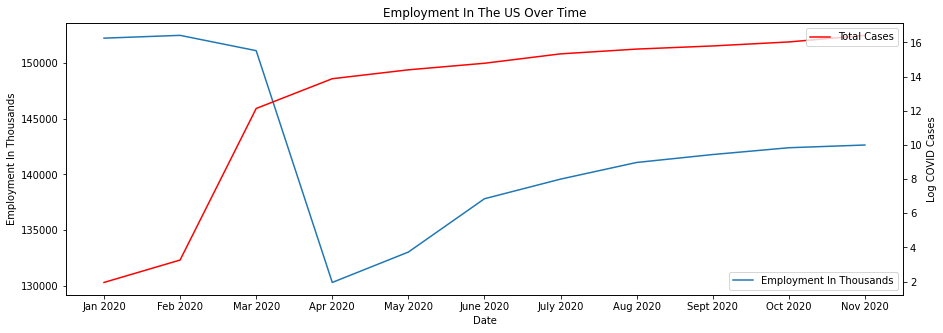

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

f["log_cases"] = np.log(f["tot_cases"])

fig, ax = plt.subplots(1,1,figsize=(15,5))
f.plot(x="Month", y="Employment In Thousands", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Employment In Thousands")
ax.set_title("Employment In The US Over Time")
ax.legend(loc="lower right")

ax2 = ax.twinx()
ax2.plot(f["Month"], f["log_cases"], color="red", label="Total Cases")
ax2.set_ylabel("Log COVID Cases")
ax2.legend(loc="upper right")

plt.show()

Although we may have expected that as COVID cases increase, employment decreases, we instead observed that employment decreased significantly between March and April. After this point, employment slowly recovered and has seemed to level off, but is below pre-pandemic levels.

February to March was when the biggest increase in log cases was observed which may have lead to the sharp decrease in employment between March and April. Following this increase, the rate of change for log covid cases decreases which may have contributed employment to begin recovering.

### How did employment vary between industries during the pandemic? 

* Were there any trends that stood out? 
* How did initial industry size play a role in employment trends during the pandemic?

The following plot overlays the employment trends for each industry with the total covid cases over time. Similar to the previous plot, we use two axes - the left y-axis represents employment in thousands and the right y-axis represents total covid cases. 

To create the plot, we took advantage of the ```df.pivot``` method which uses the Industry as a pivot to map out each indivudual trend. The black line represents the trend for total COVID and coresponds to the right y-axis. All other lines represent the industries and corespond to the left y-axis.

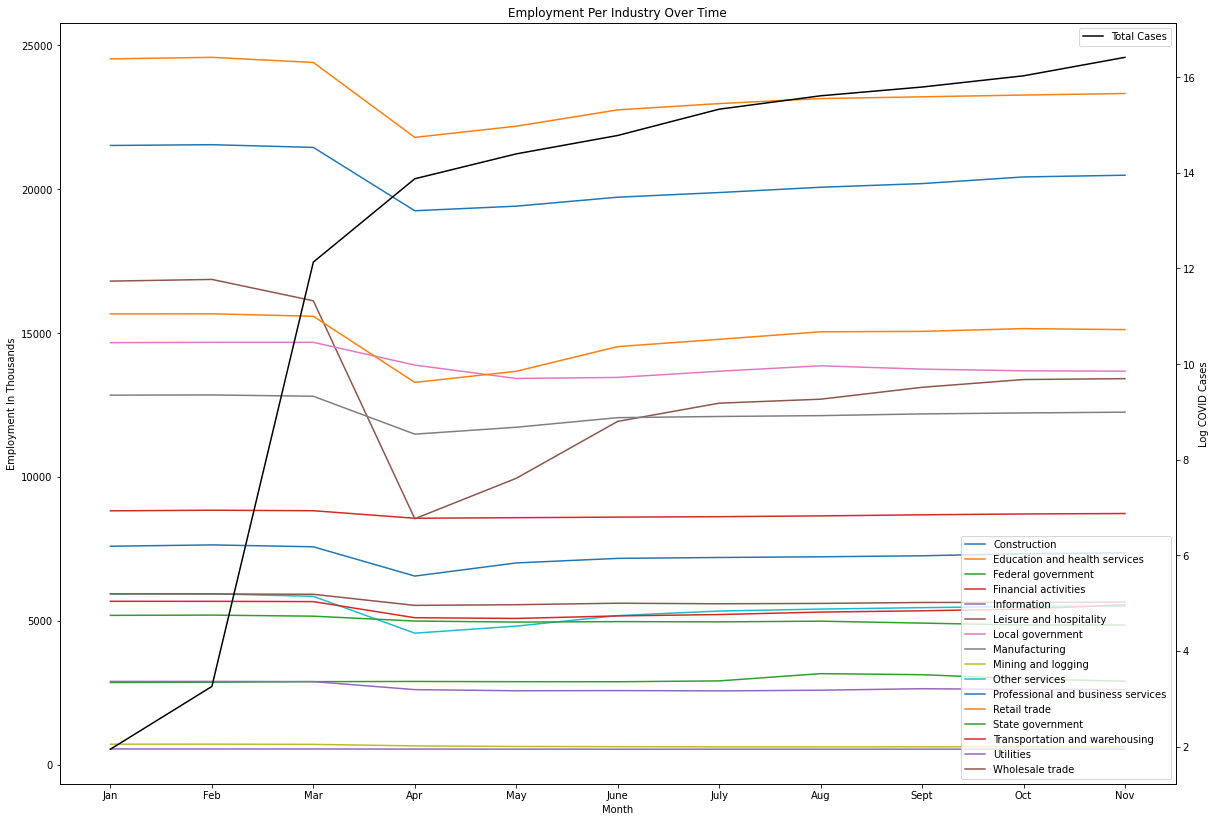

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,14))

ax2 = ax.twinx()
ax2.plot(f["Month"], np.log(f["tot_cases"]), 
         color="black",label="Total Cases")
ax2.set_ylabel("Log COVID Cases")
ax2.legend(loc="upper right")

inds = df.pivot(columns = "Industry", values="Employment In Thousands", 
                index="submission_date")
inds.plot(ylabel="Employment In Thousands", 
          ax=ax).set_title("Employment Per Industry Over Time")
ax.legend(loc="lower right")

ax.set_xticklabels(months)
ax.set_xlabel("Month")

plt.xlabel("Date")
plt.show()

The graph above looks pretty messy as there are 17 lines on a single plot. To remedy this we can divide this plot into four plots where each subplot consists of 4 industries and a line for total covid cases. 

We want the 4 industries to be somewhat close together with respect to employment in thousands. To do this we can use the ```pd.cut``` method to divide our data into four bins with respect to employment in thousands.

In [ ]:
sorted_inds = df[df["submission_date"] == "01/31/2020"]
sorted_inds = sorted_inds.sort_values("Employment In Thousands")
sorted_inds = sorted_inds[["Industry"]].reset_index()
sorted_inds["bin"] = pd.cut(sorted_inds.index, 4,labels=False)

df["bin"] = 0

for i,e in enumerate(sorted_inds["Industry"]):
    df.loc[df["Industry"] == e, "bin"] = sorted_inds["bin"][i]

Once, we have created our bins, we can plot the trends for each bin on a subplot.

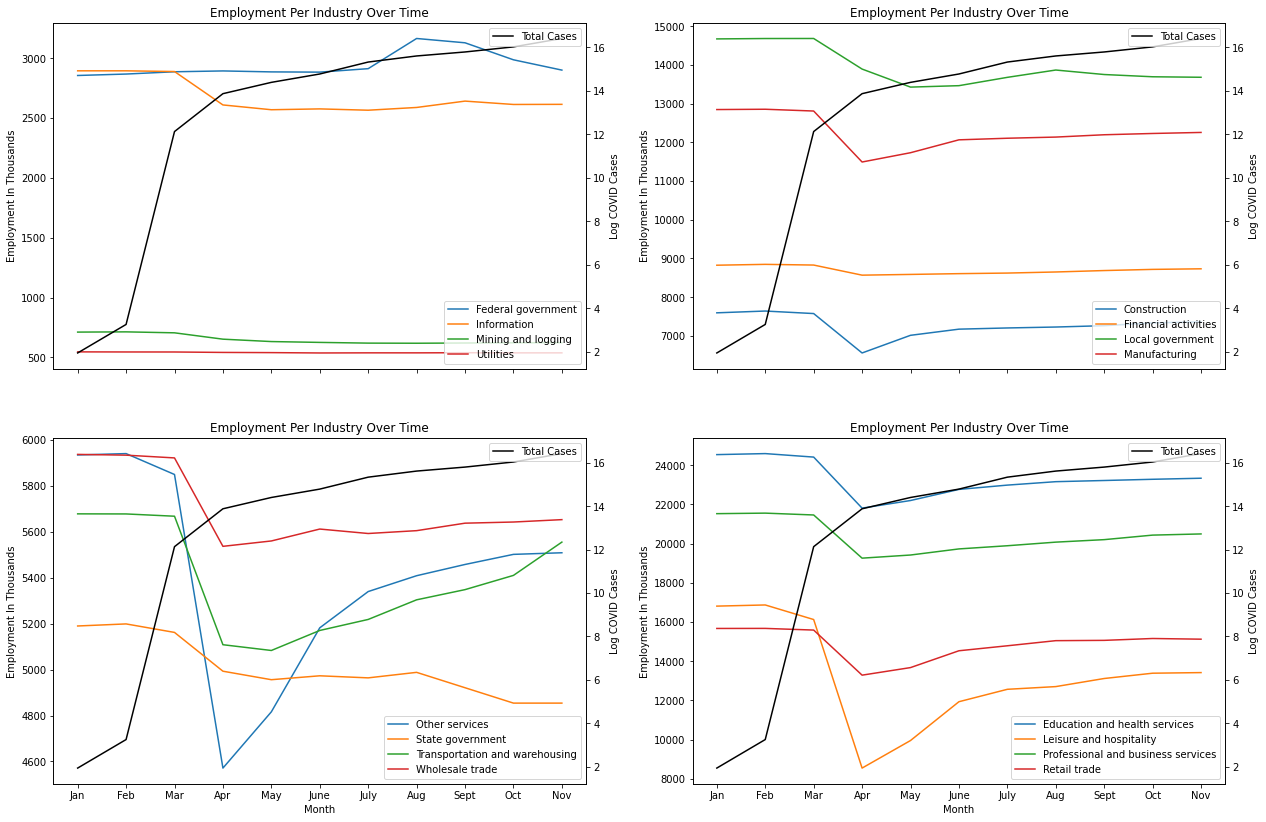

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15,14))

for i,e in enumerate(df["bin"].unique()):
    ax2 = axs[i//2][i%2].twinx()
    ax2.plot(f["submission_date"], np.log(f["tot_cases"]), color="black", 
             label="Total Cases")
    ax2.set_ylabel("Log COVID Cases")
    ax2.legend(loc="upper right")

    tf = df[df["bin"] == e].reset_index()
    
    inds = tf.pivot(columns = "Industry", values="Employment In Thousands", 
                    index="submission_date")
    
    inds.plot(figsize=[21,14],ylabel="Employment In Thousands",
              ax=axs[i//2][i%2])
    axs[i//2][i%2].set_title("Employment Per Industry Over Time")
    axs[i//2][i%2].legend(loc="lower right")

    axs[i//2][i%2].set_xticklabels(months)
    axs[i//2][i%2].set_xlabel("Month")
 
plt.show()

1. Were there any trends that stood out? 

* Unlike the general trend for the US as a whole and most industries, the federal government showed an increase in employment during the pandemic
* Both Other Services and Lesure and Hospitatlity showed sharper decreases in employment than other industries
* Employment in the State Government continued to decrease throughout the pandemic even after the March to April drop
* Employment in Transportation and Warehousing did not level off by November and seems to display a continuing upward trend.

2. How did initial industry size play a role in employment trends during the pandemic?

* In general, smaller industries seemed to have less drastic drops in employment than bigger industries. This may indicate that smaller industries were able to better retain their employment during the pandemic than larger ones.


### How did the drop in employment vary among industries between February and April?

In the previous graphs, we had seen that there was a significant initial drop between March and April. With this observation, it might be relevant to see the effect of an initial spike in log covid cases on the percent of workers who were no longer employed. 

We can define "pre-pandemic levels of employment" to be at the latest February and measure the percent drop in employment between February and April. 

In [ ]:
feb = df[df["submission_date"] == "02/29/2020"]
feb = feb.sort_values(by="Industry")["Employment In Thousands"] 

april = df[df["submission_date"] == "04/30/2020"]
april = april.sort_values(by="Industry")["Employment In Thousands"] 

inds = sorted(df["Industry"].unique())
drops = april.to_numpy()/feb.to_numpy()
drop_perc = pd.DataFrame({"Industry": inds, "Feb_To_April": 100*(1-drops)})
drop_perc.head()

,Industry,Feb_To_April
0,Construction,14.177248
1,Education and health services,11.311315
2,Federal government,-0.906871
3,Financial activities,3.154324
4,Information,9.847961


### How did the recovery of jobs vary among industries between February and November?

We can perform a similar calculation to see how each industry has recovered by November. We again measure the percent drop in employment between February and November.

In [ ]:
nov = df[df["submission_date"] == "11/30/2020"]
nov = nov.sort_values(by="Industry")["Employment In Thousands"] 

inds = sorted(df["Industry"].unique())
drops = nov.to_numpy()/feb.to_numpy()
drop_perc["Feb_To_Nov"] =  100*(1-drops)

drop_perc.head()

,Industry,Feb_To_April,Feb_To_Nov
0,Construction,14.177248,3.652311
1,Education and health services,11.311315,5.108598
2,Federal government,-0.906871,-1.151029
3,Financial activities,3.154324,1.300170
4,Information,9.847961,9.675190


Now that we have the percent drops for both April and November, we can also compare the percent drop in employment for both of these months. This gives us an indicator of how badly an industry was initially affected and how well it has recovered since the start of the pandemic.

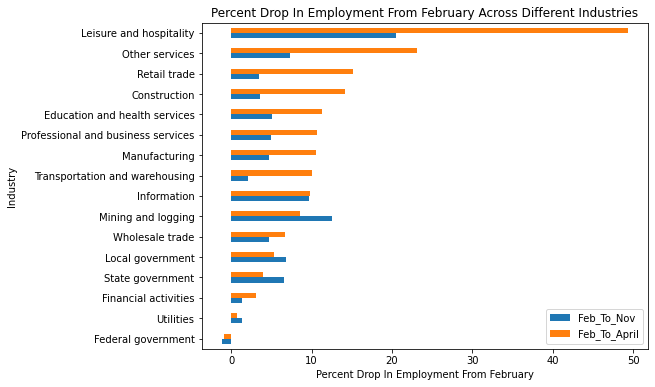

In [ ]:
drop_perc = drop_perc.sort_values(by="Feb_To_April")
drop_perc.plot.barh(x="Industry", y=["Feb_To_Nov", "Feb_To_April"], 
                    figsize=(8,6))

plt.title("Percent Drop In Employment From February Across Different Industries")
plt.xlabel("Percent Drop In Employment From February")
plt.show()

Some interesting observations to note are,

* Lesure and Hospitality took a hard hit in April, and has recovered significantly but is still lagging far behind the intial drops that most industries experienced.
* Federal Government shows negative drops in both April and November and actually shows a growth in employment throughout the pandemic.
* Some industries show very similar statistics such as Education and health services, Professional and business services, and Manufacturing. This may indicate that certain industries cluster together and have similar employment trends during a pandemic.

## Data Modeling

In this section, we create models for the data that we had explored above. We created two different models to capture the trends in the data:

* Linear Regression - predicting the employment levels using the total covid cases
* Clustering - using K-Means clustering to determine which industries had similar initial drops and overall recovery in employment

### Linear Regression

To model the relationship between covid cases and employment in thousands, we want to create a model that can predict employment based on the number of covid cases. 

To do this, we can use sklearn's LinearRegression library and use the change in log covid cases as our independent variable and the employment in thousands as our dependent variable. We want to use the change in log covid cases since we had seen that the magnitude of the increases in log covid cases seemed to be correlated with the employment across all industries.

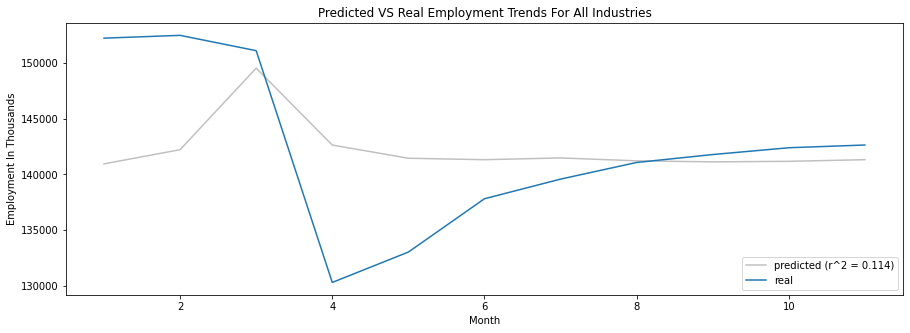

In [ ]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1,1,figsize=(15,5))

f["log_cases"] = np.log(f["tot_cases"])

X = f["log_cases"].to_numpy()
dX = X[1:] - X[:-1]
dX = np.array([0] + [e for e in dX])
dX = dX.reshape(len(dX), 1)
lin = LinearRegression().fit(dX, f["Employment In Thousands"])
r2 = lin.score(dX, f["Employment In Thousands"])

#Predicted Trend
ax.plot(f.index+1, dX*lin.coef_+lin.intercept_, 
        label="predicted (r^2 = %3.3f)" % r2, color="silver")

#Real Trend
ax.plot(f.index+1, f["Employment In Thousands"], label="real")

ax.set_xlabel("Month")
ax.set_ylabel("Employment In Thousands")
ax.legend(loc="lower right")

plt.title('Predicted VS Real Employment Trends For All Industries')
plt.show()

We can see that a linear regression is not a great fit for using covid cases to predict employment. The model is able to capture when the drop in employment occurs and seems to converge around the same level of employment in the later months. This being said, the $r^2$ value is very low at $r^2=0.114$. It is possible that we will get better fits if we create a model for each industry rather than the US as a whole.

To fit a linear regression model for each industry, we can perform a similar process that uses the change in log covid cases as the independent variable and employment in thousands for that specific industry as the dependent variable. The results can be displayed on a subplot so that we can observe all the industries on a single plot. 

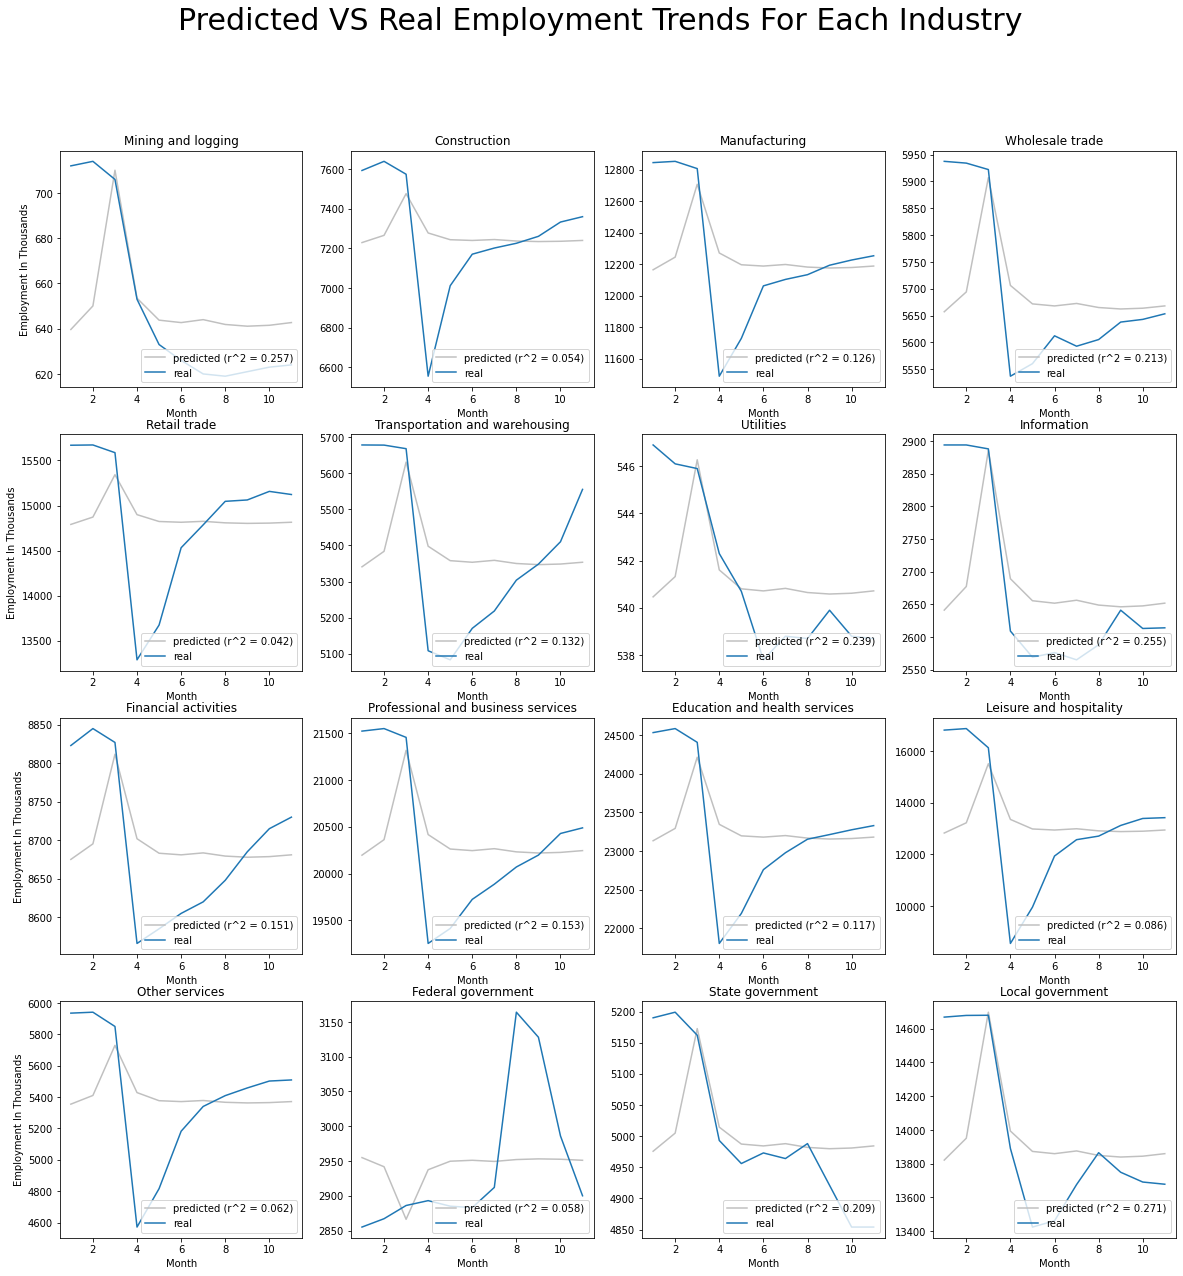

In [ ]:
fig, axs = plt.subplots(4,4,figsize=(20,20))

for i, ind in enumerate(df["Industry"].unique()):
    inds = df[df["Industry"] == ind].copy()
    inds["log_cases"] = np.log(inds["tot_cases"])
    inds["employment"] = inds["Employment In Thousands"]
    inds = inds.reset_index()

    X = inds["log_cases"].to_numpy()
    dX = X[1:] - X[:-1]
    dX = np.array([0] + [e for e in dX])
    dX = dX.reshape(len(dX), 1)
    lin = LinearRegression().fit(dX, inds["employment"])
    r2 = lin.score(dX, inds["employment"])

    ax = axs[i//4][i%4]
    #Predicted Trend
    ax.plot(inds.index+1, dX*lin.coef_+lin.intercept_, 
            label="predicted (r^2 = %3.3f)" % r2, color="silver")

    #Real Trend
    ax.plot(inds.index+1, inds["employment"], label="real")
    
    ax.set_xlabel("Month")
    if i%4 == 0: ax.set_ylabel("Employment In Thousands")
    ax.set_title(ind)
    ax.legend(loc="lower right")

fig.suptitle('Predicted VS Real Employment Trends For Each Industry', 
             fontsize=30)
plt.show()


Some interesting observations to note are,

* In general, linear regression models are not a great for this data as all of the $r^2$ values are pretty low which would not show a strong linear correlation between the two variables.
* Some predicted trends like Local Government, Information, and Mining and Logging seem to be visually close to the real trends with $r^2$ values that are higher than what we had observed for employment in the US as a whole.
* Industries where there were extreme drops or unexpected increases in employment such as Federal Government, Other Services, and Lesiure and Hospitality were not fit well by the linear regression model.

### Clustering

In our data exploration, we had seen that certain industries might have simmilar performances with regards to the initial drop due to the pandemic and how they have recovered thus far. 

We can plot these industries on a graph where the x-axis is the percent drop between February and April and the y-axis is the percent drop between February and November. 

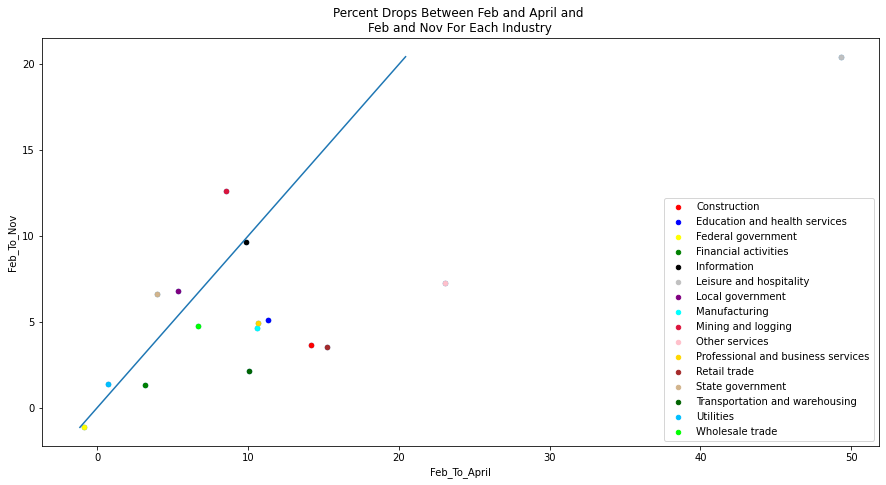

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,7.5))
drop_perc.plot.scatter("Feb_To_April", "Feb_To_Nov", ax = ax)
c = (1, 0, 0)
dc = 1/len(drop_perc["Industry"])
colors = ["red", "blue", "yellow", "green", "black", "silver", "purple", 
          "cyan", "crimson", "pink", "gold", "brown", "tan", "darkgreen",
          "deepskyblue", "lime"]

for i, e in enumerate(drop_perc["Industry"]):
    tf = drop_perc[drop_perc["Industry"] == e]
    tf.plot.scatter("Feb_To_April", "Feb_To_Nov", label=e, ax = ax, 
                    color = colors[i])
    c = (c[0]-dc,0,c[2]+dc)
    #plt.text(drop_perc["Feb_To_April"][i], drop_perc["Feb_To_Nov"][i], e)
plt.plot(sorted(drop_perc["Feb_To_Nov"]), sorted(drop_perc["Feb_To_Nov"]))
plt.title("Percent Drops Between Feb and April and \nFeb and Nov For Each Industry")
#plt.xlim(right=75)
plt.show()

In the plot above, the blue line represents no change between the percent drop from February to April and February To November. 

* Industries above the line have a lower employment in November than they did after the initial drop in April.
* Industries below the line have a higher employment in November than they did in April.
* Industries on the line have remained static since April and their employment numbers have not significantly changed


To group these industries together, we can take advantage of clustering. We use a K-Means approach to identify clusters in the data with respect to the percent drops between February and April and February and November.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

dpfa = drop_perc["Feb_To_April"]
X = [[e, drop_perc["Feb_To_Nov"].iloc[i]] for i,e in enumerate(dpfa)]
X = np.array(X)

kmeans = KMeans(n_clusters=5).fit(X)

drop_perc["cluster"] = kmeans.labels_
drop_perc.head()

,Industry,Feb_To_April,Feb_To_Nov,cluster
2,Federal government,-0.906871,-1.151029,3
14,Utilities,0.695843,1.355063,3
3,Financial activities,3.154324,1.300170,3
12,State government,3.962300,6.635892,0
6,Local government,5.375026,6.819266,0


Now that we have our assigned clusters, we can plot all of our industries again, this time with the color of the point representing the cluster they belong to

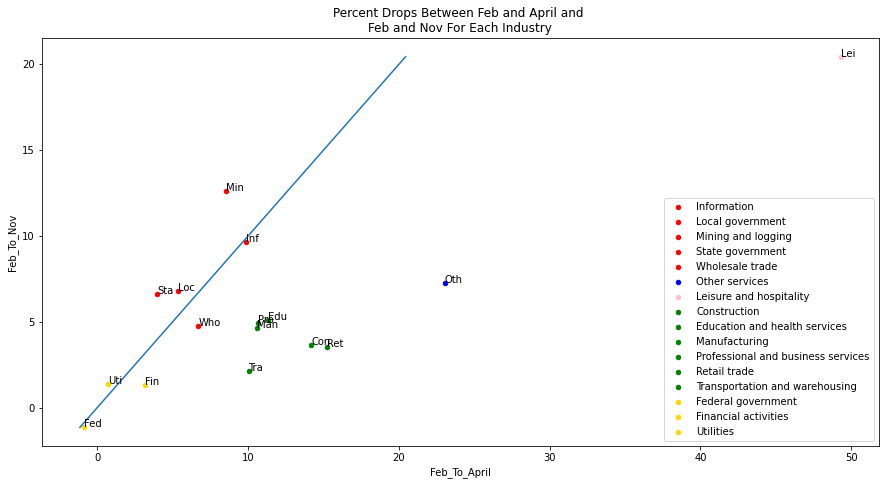

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,7.5))

colors = ["red", "blue", "pink", "green", "gold", "silver", "yellow", 
          "cyan", "crimson", "pink", "gold", "brown", "tan", "darkgreen", 
          "deepskyblue", "lime"]

drop_perc = drop_perc.sort_values(by="cluster")

for i, e in enumerate(drop_perc["Industry"]):
    tf = drop_perc[drop_perc["Industry"] == e]
    tf.plot.scatter("Feb_To_April", "Feb_To_Nov", ax = ax, 
                    color = colors[drop_perc["cluster"].iloc[i]], label=e)

for i, e in enumerate(drop_perc["Industry"]):
    plt.text(drop_perc["Feb_To_April"].iloc[i], 
             drop_perc["Feb_To_Nov"].iloc[i], 
             e[:3])

plt.plot(sorted(drop_perc["Feb_To_Nov"]), sorted(drop_perc["Feb_To_Nov"]))
plt.title("Percent Drops Between Feb and April and \nFeb and Nov For Each Industry")
#plt.xlim(right=75)

plt.show()

We used a model with five clusters. Below, we talk about each cluster and discuss why certain industries are grouped together. From each cluster, we also chose one industry to find a external source for and investigate why it belongs to that cluster:

* The first cluster located in the bottom left of the plot were the industries affected the least. The first cluster, federal government, financial activities, and utilities didn't change significantly, and federal government actually increased in employment. [For utilities, there is less of a demand, but still a significant one](https://www.utilitydive.com/news/the-effects-of-coronavirus-measures-on-electricity-markets/576296/). Industries like financial activities and the federal government may have experienced a similar robustness to the pandemic due to this stable demand.

* The second cluster, information, local government, mining and logging, state government, and wholesale trade are closer or above the y=x line. The industries above the line have an even lower employment number in November than in April. Overall, this cluster was hurt significantly, and has yet to recover significantly. [In Wholesale trade, there is a lower demand. A reduction in exports to America's largest consumers has led to a decrease in supply and increase in domestic prices.](https://www.ibisworld.com/industry-insider/coronavirus-insights/coronavirus-update-industry-fast-facts/#Wholesale). Due to the pandemic halting trade and work in these industries, the level of employment for these industries will take longer to recover than industries in other clusters.

* The third cluster, construction, education and health services, manufacturing, professional and business services, retail trade ,and transportation and warehousing were all affected significantly, but recovered a fair amount. [Manufacturing has decreased significantly because there is less global trade, but as the economy increases, it will continue to recover, even if it doesn't reach pre-pandemic levels.](https://www.bofaml.com/en-us/content/coronavirus-impact-on-manufacturing-industry.html). As the global economy recovers and covid cases drop, even if covid cases in the US continue to accelerate, this global demand may have helped some of these industries recover in a shorter period of time as compared to industries in other clusters.

* The fourth cluster, is a lone node of leisure and hospitality sitting in the top right of the graph. This industry was affected the worse and has recovered somewhat. [People are social distancing and there are laws about large gatherings in many states. Because of this, places for travel and gathering like hotels are impacted negatively.](
https://www.brookings.edu/blog/the-avenue/2020/08/20/back-to-work-in-the-flames-the-hospitality-sector-in-a-pandemic/)

* The fifth cluster consists of the Other Services Industry. Other Services can consist of many industries and it could capture the variability of different clusters. This could explain why the Other Services industry was separate from all others on the plot.

## Conclusion

Through this tutorial, we have analyzed the trends in employment data across various industries during the COVID-19 pandemic. Some of our key conclusions were:

* Not all industries were equally affected by the COVID-19 Pandemic. Industries varied greatly in how badly they were initially affected and their recovery. 
* A linear regression model is not the best model to use to predict employment trends based on COVID cases. All employment trends were weakly correlated with COVID cases, but the $r^2$ value was non-zero. This may indicate that there may be a different relationship that exists between these two variables that could be captured by a non-linear model.  
* Some industries are relatively robust to pandemics due to stable demand and supply; this can also be attributed to the fact that these industries offer necessities to consumers.
* Trends for certain industries were similar which may indicate that these industries share factors that can be used to predict their level of employment during a pandemic. Although data doesn't exist on characteristics for each industry, the clusters indicated certain factors that could be used by future models:
    * Global trade
    * Necessity of services
    * Cost of delays
    * Succeptibility of COVID-19 to workers
    * Policies enacted 

In the future, other investigators may want to explore:

* using a non-linear model for the relationship between pandemic employment figures and the number of people infected
* labeling industries with certain factors that can be used to classify how they will perform during a pandemic
* understanding the impacts of the timetable of releasing a vaccine on employment figures
* generalizing these results to other pandemics or similar events
* generalizing these results to other countries and comparing them to the results we found with the US

Understanding the employment trends that exist during a pandemic will not only continue to be useful during COVID-19, but will help us prepare for future pandemics and avoid the outcome that we have seen with COVID-19. Future US government officials can use this data to set up infrastructure and direct aid to industries that have shown to be more negatively impacted by this pandemic. 
